### Quick Start

The `LANfactory` package is a light-weight convenience package for training `likelihood approximation networks` (LANs) in torch (or keras), 
starting from supplied training data.

[LANs](https://elifesciences.org/articles/65074), although more general in potential scope of applications, were conceived in the context of sequential sampling modeling
to account for cognitive processes giving rise to *choice* and *reaction time* data in *n-alternative forced choice experiments* commonly encountered in the cognitive sciences.

In this quick tutorial we will use the [`ssms`](https://github.com/AlexanderFengler/ssm_simulators) package to generate our training data using such a sequential sampling model (SSM). The use of of the `LANfactory` package is in no way bound to utilize this `ssms` package.

#### Install

To install the `ssms` package type,

`pip install git+https://github.com/AlexanderFengler/ssm_simulators`

To install the `LANfactory` package type,

`pip install git+https://github.com/AlexanderFengler/LANfactory`

Necessary dependency should be installed automatically in the process.

#### Basic Tutorial

In [1]:
# Load necessary packages
import ssms
import lanfactory
import os
import numpy as np
from copy import deepcopy
import torch

passing 1
wandb not available
wandb not available


#### Generate Training Data
First we need to generate some training data. As mentioned above we will do so using the `ssms` python package, however without delving into a detailed explanation
of this package. Please refer to the [basic ssms tutorial] (https://github.com/AlexanderFengler/ssm_simulators) in case you want to learn more.

In [2]:
# MAKE CONFIGS
model = "ddm_deadline"
# Initialize the generator config (for MLP LANs)
generator_config = deepcopy(ssms.config.data_generator_config["lan"])
# Specify generative model (one from the list of included models mentioned above)
generator_config["model"] = model
# Specify number of parameter sets to simulate
generator_config["n_parameter_sets"] = 10000
# Specify how many samples a simulation run should entail
generator_config["n_samples"] = 1000
# Specify folder in which to save generated data
generator_config["output_folder"] = "data/lan_mlp/" + model + "/"

# Make model config dict
model_config = ssms.config.model_config[model.split("_deadline")[0]]

In [6]:
# MAKE DATA

my_dataset_generator = ssms.dataset_generators.lan_mlp.data_generator(
    generator_config=generator_config, model_config=model_config
)

for i in range(50):
    print(i)
    training_data = my_dataset_generator.generate_data_training_uniform(save=True)

{'name': 'angle_deadline', 'params': ['v', 'a', 'z', 't', 'theta', 'deadline'], 'param_bounds': [[-3.0, 0.3, 0.1, 0.001, -0.1, 0.001], [3.0, 3.0, 0.9, 2.0, 1.3, 10]], 'boundary_name': 'angle', 'boundary': <function angle at 0x10724e9e0>, 'n_params': 6, 'default_params': [0.0, 1.0, 0.5, 0.001, 0.0, 10], 'nchoices': 2, 'simulator': <cyfunction ddm_flexbound at 0x1178ae400>}
n_cpus used:  12
checking:  data/lan_mlp/angle_deadline/
0
simulation round: 1  of 10
simulation round: 2  of 10
simulation round: 3  of 10
simulation round: 4  of 10
simulation round: 5  of 10
simulation round: 6  of 10
simulation round: 7  of 10
simulation round: 8  of 10
simulation round: 9  of 10
simulation round: 10  of 10
Writing to file:  data/lan_mlp/angle_deadline//training_data_10b7958ac17511ee838f6ae25f443f62.pickle
1
simulation round: 1  of 10
simulation round: 2  of 10
simulation round: 3  of 10
simulation round: 4  of 10
simulation round: 5  of 10
simulation round: 6  of 10
simulation round: 7  of 10
sim

In [ ]:
# training_data

'Dataset completed'

#### Prepare for Training

Next we set up dataloaders for training with pytorch. The `LANfactory` uses custom dataloaders, taking into account particularities of the expected training data.
Specifically, we expect to receive a bunch of training data files (the present example generates only one), where each file hosts a large number of training examples. 
So we want to define a dataloader which spits out batches from data with a specific training data file, and keeps checking when to load in a new file. 
The way this is implemented here, is via the `DatasetTorch` class in `lanfactory.trainers`, which inherits from `torch.utils.data.Dataset` and prespecifies a `batch_size`. Finally this is supplied to a [`DataLoader`](https://pytorch.org/docs/stable/data.html), for which we keep the `batch_size` argument at 0.

The `DatasetTorch` class is then called as an iterator via the DataLoader and takes care of batching as well as file loading internally. 

You may choose your own way of defining the `DataLoader` classes, downstream you are simply expected to supply one.

In [3]:
# MAKE DATALOADERS

# List of datafiles (here only one)
folder_ = "data/lan_mlp/" + model + "/"  # + "/training_data_0_nbins_0_n_1000/"
file_list_ = [folder_ + file_ for file_ in os.listdir(folder_)]
feature_key = "opn_data"
label_key = "opn_labels"

# Training dataset
torch_training_dataset = lanfactory.trainers.DatasetTorch(
    file_ids=file_list_,
    batch_size=2048,
    features_key=feature_key,
    label_key=label_key,
)

torch_training_dataloader = torch.utils.data.DataLoader(
    torch_training_dataset,
    shuffle=True,
    batch_size=None,
    num_workers=1,
    pin_memory=True,
)

# Validation dataset
torch_validation_dataset = lanfactory.trainers.DatasetTorch(
    file_ids=file_list_,
    batch_size=2048,
    features_key=feature_key,
    label_key=label_key,
)

torch_validation_dataloader = torch.utils.data.DataLoader(
    torch_validation_dataset,
    shuffle=True,
    batch_size=None,
    num_workers=1,
    pin_memory=True,
)

Now we define two configuration dictionariers,

1. The `network_config` dictionary defines the architecture and properties of the network
2. The `train_config` dictionary defines properties concerning training hyperparameters

Two examples (which we take as provided by the package, but which you can adjust according to your needs) are provided below.

In [4]:
# SPECIFY NETWORK CONFIGS AND TRAINING CONFIGS
network_type = "opn"
if network_type == "cpn":
    network_config = lanfactory.config.network_configs.network_config_cpn
    train_config = lanfactory.config.network_configs.train_config_cpn
elif network_type == "lan":
    network_config = lanfactory.config.network_configs.network_config_mlp
    train_config = lanfactory.config.network_configs.train_config_mlp
elif network_type == "opn":
    network_config = lanfactory.config.network_configs.network_config_cpn
    train_config = lanfactory.config.network_configs.train_config_cpn

print("Network config: ")
print(network_config)

print("Train config: ")
print(train_config)

Network config: 
{'layer_sizes': [100, 100, 1], 'activations': ['tanh', 'tanh', 'linear'], 'train_output_type': 'logits'}
Train config: 
{'cpu_batch_size': 128, 'gpu_batch_size': 256, 'n_epochs': 5, 'optimizer': 'adam', 'learning_rate': 0.002, 'lr_scheduler': 'reduce_on_plateau', 'lr_scheduler_params': {}, 'weight_decay': 0.0, 'loss': 'bcelogit', 'save_history': True}


We can now load a network, and save the configuration files for convenience.

In [5]:
# LOAD NETWORK
network_config["layer_sizes"] = [100, 100, 100, 100, 1]
network_config["activations"] = ["tanh", "tanh", "tanh", "tanh", "linear"]

net = lanfactory.trainers.TorchMLP(
    network_config=deepcopy(network_config),
    input_shape=torch_training_dataset.input_dim,
    save_folder="data/torch_models/" + model + "/",
    generative_model_id="angle",
)

# SAVE CONFIGS
lanfactory.utils.save_configs(
    model_id=model + "_torch_",
    save_folder="data/torch_models/" + model + "/",
    network_config=network_config,
    train_config=train_config,
    allow_abs_path_folder_generation=True,
)

tanh
tanh
tanh
tanh
linear
Found folder:  data
Moving on...
Found folder:  data/torch_models
Moving on...
Found folder:  data/torch_models/ddm_deadline
Moving on...
Saved network config
Saved train config


In [ ]:
# train_config

# train_config["n_epochs"] = 25

To finally train the network we supply our network, the dataloaders and training config to the `ModelTrainerTorchMLP` class, from `lanfactory.trainers`.

In [6]:
# TRAIN MODEL
n_epochs = 20
train_config["n_epochs"] = n_epochs

model_trainer = lanfactory.trainers.ModelTrainerTorchMLP(
    model=net,
    train_config=train_config,
    train_dl=torch_training_dataloader,
    valid_dl=torch_validation_dataloader,
    allow_abs_path_folder_generation=False,
    pin_memory=True,
    seed=None,
)

# model_trainer.train_model(save_history=True, save_model=True, verbose=0)
model_trainer.train_and_evaluate(
    wandb_on=0,
    output_folder="data/torch_models/" + model + "_opn/",
    output_file_id=model,
)
# LOAD MODEL

Torch Device:  cpu
Found folder:  data
Moving on...
Found folder:  data/torch_models
Moving on...
Found folder:  data/torch_models/ddm_deadline_opn
Moving on...
passing 1
wandb not available
wandb not available
epoch: 0 / 20, batch: 0 / 200, batch_loss: 0.71523118019104
epoch: 0 / 20, batch: 100 / 200, batch_loss: 0.15025952458381653
Epoch took 0 / 20,  took 12.753804922103882 seconds
passing 1
wandb not available
wandb not available
epoch 0 / 20, validation_loss: 0.1452
passing 1
wandb not available
wandb not available
epoch: 1 / 20, batch: 0 / 200, batch_loss: 0.1448168307542801
epoch: 1 / 20, batch: 100 / 200, batch_loss: 0.14321260154247284
Epoch took 1 / 20,  took 11.158228874206543 seconds
passing 1
wandb not available
wandb not available
epoch 1 / 20, validation_loss: 0.143
passing 1
wandb not available
wandb not available
epoch: 2 / 20, batch: 0 / 200, batch_loss: 0.14219547808170319
epoch: 2 / 20, batch: 100 / 200, batch_loss: 0.14337749779224396
Epoch took 2 / 20,  took 11.41

#### Load Model for Inference and Call

The `LANfactory` provides some convenience functions to use networks for inference after training. 
We can load a model using the `LoadTorchMLPInfer` class, which then allows us to run fast inference via either
a direct call, which expects a `torch.tensor` as input, or the `predict_on_batch` method, which expects a `numpy.array` 
of `dtype`, `np.float32`. 

In [7]:
network_path_list = os.listdir("data/torch_models/" + model + "_opn")
network_file_path = [
    "data/torch_models/" + model + "_opn" + "/" + file_
    for file_ in network_path_list
    if "state_dict" in file_
][0]

network = lanfactory.trainers.LoadTorchMLPInfer(
    model_file_path=network_file_path,
    network_config=network_config,
    input_dim=torch_training_dataset.input_dim,
)

tanh
tanh
tanh
tanh
linear


In [8]:
# Two ways to call the network

# Direct call --> need tensor input
direct_out = network(
    torch.from_numpy(np.array([1, 1.5, 0.5, 1.0, 1], dtype=np.float32))
)
print("direct call out: ", direct_out)

# predict_on_batch method
predict_on_batch_out = network.predict_on_batch(
    np.array([1, 1.5, 0.5, 1.0, 1], dtype=np.float32)
)
print("predict_on_batch out: ", predict_on_batch_out)

direct call out:  tensor([-0.0048])
predict_on_batch out:  [-0.00476831]


#### A peek into the first passage distribution computed by the network

We can compare the learned likelihood function in our `network` with simulation data from the underlying generative model.
For this purpose we recruit the [`ssms`](https://github.com/AlexanderFengler/ssm_simulators) package again.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.DataFrame(
    np.zeros((2000, 5), dtype=np.float32),
    columns=["v", "a", "z", "t", "deadline"],
)
data["v"] = np.linspace(-2.0, 2.0, 2000)
data["a"] = 2.0
data["z"] = 0.5
data["t"] = 0.5
# data["theta"] = 0.0
data["deadline"] = 2.0

# Network predictions
network_predictions = []

# Simulations
from ssms.basic_simulators.simulator import simulator

omission_p_vec = np.zeros((20, 40))  # np.zeros(20, 20)
for i, deadline in enumerate(np.linspace(0.5, 2.5, 20)):
    data["v"] = np.linspace(-2.0, 2.0, 2000)
    data["deadline"] = deadline
    network_predictions.append(network.predict_on_batch(data.values.astype(np.float32)))
    for j, v in enumerate(np.linspace(-2.0, 2.0, 40)):
        data["v"] = v
        sim_out = simulator(model=model, theta=data.values[0, :], n_samples=5000)
        omission_p_vec[i, j] = sim_out["omission_p"][0, 0]

/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_ssm_simulators/ssm-simulators/ssms/basic_simulators/simulator.py:399: UserWarning: Deadline model request, and theta not supplied as dict.Make sure to supply the deadline parameters in last position!
  warnings.warn(


In [ ]:
# sim_out['omission_p']

Text(0, 0.5, 'omission_p')

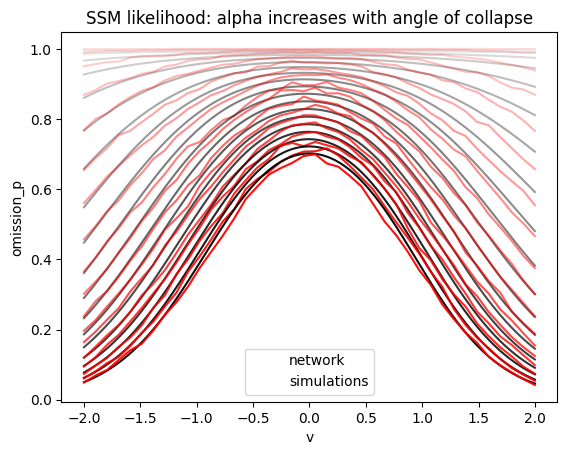

In [10]:
# Plot network predictions
# Plot simulations
for i in range(20):
    plt.plot(
        np.linspace(-2, 2, 2000),
        np.exp(network_predictions[i]),
        color="black",
        label=None if i > 0 else "network",
        alpha=i / 20,
    )

    plt.plot(
        np.linspace(-2, 2, 40),
        np.array(omission_p_vec[i, :]),
        color="red",
        label=None if i > 0 else "simulations",
        alpha=i / 20,
    )

plt.legend()
plt.title("SSM likelihood: alpha increases with angle of collapse")
plt.xlabel("v")
plt.ylabel("omission_p")

In [22]:
data.values[0, :]

array([-0.46153846,  2.        ,  0.5       ,  0.5       ,  1.55263158])

In [34]:
# data

In [41]:
model

'ddm_deadline'

In [35]:
my_params

['v', 'a', 'z', 't', 'deadline']

In [39]:
np.array([data[k] for k in my_params]).astype(np.float32)

array([-2. ,  2. ,  0.5,  0.5,  0.5], dtype=float32)

In [42]:
my_params

['v', 'a', 'z', 't', 'deadline', 'deadline']

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from ssms.basic_simulators.simulator import simulator

data = pd.DataFrame(
    np.zeros((2000, 5), dtype=np.float32),
    columns=["v", "a", "z", "t", "deadline"],
)

data = {"v": 0, "a": 2.0, "z": 0.5, "t": 0.5, "deadline": 2.0}

my_params = deepcopy(ssms.config.model_config[model.split("_deadline")[0]]["params"])
my_params.append("deadline")

# data["v"] = np.linspace(-2., 2., 2000)
# data["a"] = 2.0
# data["z"] = 0.5
# data["t"] = 0.5
# data["theta"] = 0.0
# data["deadline"] = 2.

# Network predictions
# network_predictions = []

# Simulations
omission_p_vec = np.zeros((5, 40))  # np.zeros(20, 20)
network_predictions = np.zeros((5, 40))

for i, deadline in enumerate(np.linspace(0.5, 1.0, 5)):
    # data["v"] = np.linspace(-2., 2., 2000)
    # data["deadline"] = deadline
    # network_predictions.append(network.predict_on_batch(data.values.astype(np.float32)))
    for j, v in enumerate(np.linspace(-2.0, 2.0, 40)):
        data["deadline"] = deadline
        data["v"] = v

        network_predictions[i, j] = network.predict_on_batch(
            np.array([data[k] for k in my_params]).astype(np.float32)
        )
        sim_out = simulator(model=model, theta=data, n_samples=2000)

        omission_p_vec[i, j] = sim_out["omission_p"][0, 0]

NameError: name 'network' is not defined

Text(0, 0.5, 'omission_p')

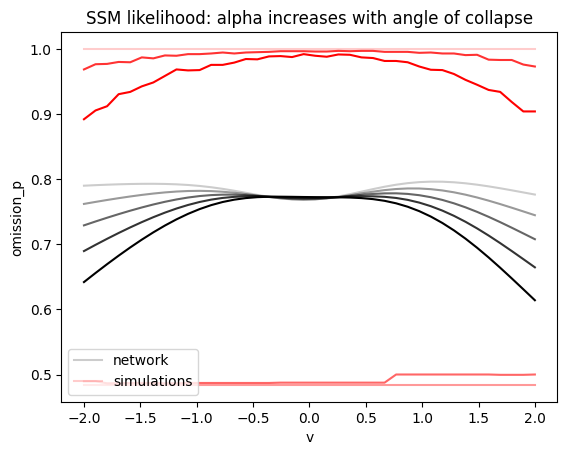

In [26]:
# Plot network predictions
# Plot simulations
for i in range(5):
    plt.plot(
        np.linspace(-2, 2, 40),
        np.exp(network_predictions[i, :]),
        color="black",
        label=None if i > 0 else "network",
        alpha=min((i + 1) / 5, 1),
    )
    plt.plot(
        np.linspace(-2, 2, 40),
        np.array(omission_p_vec[i, :]),
        color="red",
        label=None if i > 0 else "simulations",
        alpha=min((i + 1) / 5, 1),
    )

plt.legend()
plt.title("SSM likelihood: alpha increases with angle of collapse")
plt.xlabel("v")
plt.ylabel("omission_p")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from ssms.basic_simulators.simulator import simulator

data = pd.DataFrame(
    np.zeros((2000, 5), dtype=np.float32),
    columns=["v", "a", "z", "t", "deadline"],
)

data = {"v": 0, "a": 1.0, "z": 0.5, "t": 0.5, "deadline": 2.0}

my_params = deepcopy(ssms.config.model_config[model.split("_deadline")[0]]["params"])
my_params.append("deadline")

# data["v"] = np.linspace(-2., 2., 2000)
# data["a"] = 2.0
# data["z"] = 0.5
# data["t"] = 0.5
# data["theta"] = 0.0
# data["deadline"] = 2.

# Network predictions
# network_predictions = []

# Simulations
omission_p_vec = np.zeros((200))  # np.zeros(20, 20)

for i, deadline in enumerate(np.linspace(0.5, 1.0, 200)):
    # data["v"] = np.linspace(-2., 2., 2000)
    # data["deadline"] = deadline
    # network_predictions.append(network.predict_on_batch(data.values.astype(np.float32)))

    data["deadline"] = deadline
    # data["v"] = v

    # network_predictions[i, j] = network.predict_on_batch(np.array([data[k] for k in my_params]).astype(np.float32))
    sim_out = simulator(model=model, theta=data, n_samples=2000)

    omission_p_vec[i] = sim_out["omission_p"][0, 0]

[0.5]
[0.5025126]
[0.50502515]
[0.50753766]
[0.51005024]
[0.5125628]
[0.5150754]
[0.51758796]
[0.5201005]
[0.52261305]
[0.5251256]
[0.5276382]
[0.5301508]
[0.53266335]
[0.53517586]
[0.53768843]
[0.540201]
[0.5427136]
[0.54522616]
[0.5477387]
[0.55025125]
[0.5527638]
[0.5552764]
[0.55778897]
[0.5603015]
[0.56281406]
[0.56532663]
[0.5678392]
[0.5703518]
[0.5728643]
[0.57537687]
[0.57788944]
[0.580402]
[0.5829146]
[0.58542717]
[0.5879397]
[0.59045225]
[0.5929648]
[0.5954774]
[0.59799]
[0.6005025]
[0.60301507]
[0.60552764]
[0.6080402]
[0.6105528]
[0.6130653]
[0.6155779]
[0.61809045]
[0.620603]
[0.6231156]
[0.6256281]
[0.6281407]
[0.63065326]
[0.63316584]
[0.6356784]
[0.6381909]
[0.6407035]
[0.6432161]
[0.64572865]
[0.6482412]
[0.6507538]
[0.6532663]
[0.6557789]
[0.65829146]
[0.66080403]
[0.6633166]
[0.6658291]
[0.6683417]
[0.6708543]
[0.67336684]
[0.6758794]
[0.67839193]
[0.6809045]
[0.6834171]
[0.68592966]
[0.68844223]
[0.69095474]
[0.6934673]
[0.6959799]
[0.69849247]
[0.70100504]
[0.7035

In [9]:
sim_out = simulator(model=model, theta=data, n_samples=2000)

[1.]


In [15]:
sim_out["rts"][sim_out["rts"] >= 1]

array([], dtype=float32)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'omission_p')

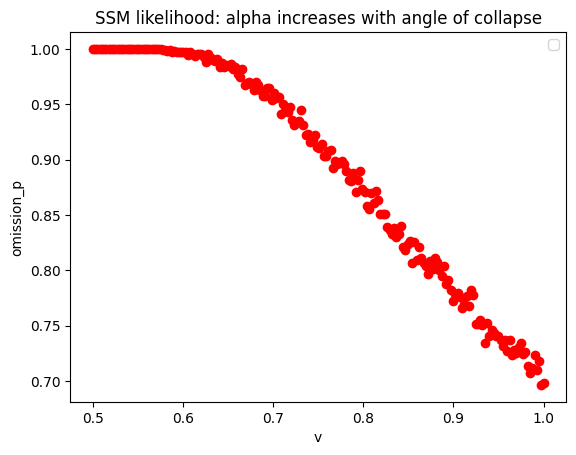

In [4]:
plt.scatter(
    np.linspace(0.5, 1.0, 200),
    np.array(omission_p_vec),
    color="red",
    label=None if i > 0 else "simulations",
)

plt.legend()
plt.title("SSM likelihood: alpha increases with angle of collapse")
plt.xlabel("v")
plt.ylabel("omission_p")

We hope this package may be helpful in case you attempt to train [LANs](https://elifesciences.org/articles/65074) for your own research.

#### END